# Préliminaires

Afin de faciliter l'exécution de modèles, ce Notebook est conçu en deux parties distinctes :

1. Analyse exploratoire 
2. Modélisation

Chaque partie contient son propre module pour charger les bibliothèques, ainsi que pour loader les données. Les parties peuvent donc être ecéxutées séparémment.

Le notebook était éxécuté à l'aide de GPU dans l'environnement de Google colab.

# Analyse exploratoire

## Charger les bibliothèques et importer les données

In [0]:
# Pointer vers gdrive
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/Projet\ 8

/content/gdrive/My Drive/Colab Notebooks/Projet 8


In [0]:
import numpy as np 
import pandas as pd 
from tqdm.auto import tqdm
from glob import glob
import time, gc
import os 
import cv2
import pydot

import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont 
from matplotlib import pyplot as plt 
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
import seaborn as sns
from IPython.display import SVG

Tout d'abord, nous allons explorer la structure de fichiers de données. 

In [0]:
# Explore the data files
for dirname, _, filenames in os.walk('Data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Data/bengaliai-cv19(1).zip
Data/bengaliai-cv19/class_map.csv
Data/bengaliai-cv19/sample_submission.csv
Data/bengaliai-cv19/test.csv
Data/bengaliai-cv19/test_image_data_0.parquet
Data/bengaliai-cv19/test_image_data_1.parquet
Data/bengaliai-cv19/test_image_data_2.parquet
Data/bengaliai-cv19/test_image_data_3.parquet
Data/bengaliai-cv19/train.csv
Data/bengaliai-cv19/train_image_data_0.parquet
Data/bengaliai-cv19/train_image_data_1.parquet
Data/bengaliai-cv19/train_image_data_2.parquet
Data/bengaliai-cv19/train_image_data_3.parquet
Data/bengaliai/Hind_Siliguri_Medium_500.ttf


Les photos sont stockées sous format .parquet dans 4 fichiers distincts. La taille originale d'images est 137 x 236 pixels. Il s'agit d'images en noir et blanc (nombre de canaux est donc 1).

In [0]:
train_df_ = pd.read_csv('Data/bengaliai-cv19/train.csv')# !!! Personnaliser le chemin
test_df_ = pd.read_csv('Data/bengaliai-cv19/test.csv')
class_map_df = pd.read_csv('Data/bengaliai-cv19/class_map.csv')
sample_sub_df = pd.read_csv('Data/bengaliai-cv19/sample_submission.csv')

In [0]:
train_df_.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


Le fichier train contient :
- **image_id** : la clé qui pointe vers le fichier .parquet
- **grapheme_root** : première classe cible, la racine de graphème
- **vowel_diacritic** : deuxième classe cible, diacritique voyelle
- **consonant_diacritique** : troisième classe cible, dicritique consonne
- **grapheme** : le caractère représenté par la police de bengali

In [0]:
test_df_.head()

,row_id,image_id,component
0,Test_0_consonant_diacritic,Test_0,consonant_diacritic
1,Test_0_grapheme_root,Test_0,grapheme_root
2,Test_0_vowel_diacritic,Test_0,vowel_diacritic
3,Test_1_consonant_diacritic,Test_1,consonant_diacritic
4,Test_1_grapheme_root,Test_1,grapheme_root


In [0]:
sample_sub_df.head()

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,0
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,0


In [0]:
class_map_df.head()

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই


In [0]:
print(f"Taille de données d'entraînement: {train_df_.shape}")
print(f"Taille de données de test: {test_df_.shape}")
print(f"Taille de class map: {class_map_df.shape}")

Taille de données d'entraînement: (200840, 5)
Taille de données de test: (36, 3)
Taille de class map: (186, 3)


## Fonctions support

In [0]:
HEIGHT = 236
WIDTH = 236

def get_n(df, field, n, top=True):
    """Function which identify n most present graphemes:
    ARGS : 
    - df : data frame
    - field : column to explore
    - n : number of top graphemes to be displayed
    - top : takes the most frequent values if True, the least frequent values if false 
    
    OUTPUT : Dataframe containing n most / least frequent graphemes and their frequencies
    
    Source Kernel : Bengali Graphemes_Starter EDA+ Multi Output CNN
    """
    
    top_graphemes = df.groupby([field]).size().reset_index(name='counts')['counts'].sort_values(ascending=not top)[:n]
    top_grapheme_roots = top_graphemes.index
    top_grapheme_counts = top_graphemes.values
    top_graphemes = class_map_df[class_map_df['component_type'] == field].reset_index().iloc[top_grapheme_roots]
    top_graphemes.drop(['component_type', 'label'], axis=1, inplace=True)
    top_graphemes.loc[:, 'count'] = top_grapheme_counts
    return top_graphemes

def image_from_char(char):
    
    """Display the police graphemes in form of images
    ARGS :
    - a grapheme
    
    OUTPUT : 
    - an image displaying the grapheme
    
    Source Kernel : Bengali Graphemes_Starter EDA+ Multi Output CNN
    """
    
    image = Image.new('RGB', (WIDTH, HEIGHT))
    draw = ImageDraw.Draw(image)
    myfont = ImageFont.truetype('Data/bengaliai/Hind_Siliguri_Medium_500.ttf', 120) # !!! Télécharger un fichier de police 
    # bengali sur internet en format .ttf et définir son emplacement 
    w, h = draw.textsize(char, font=myfont)
    draw.text(((WIDTH - w) / 2,(HEIGHT - h) / 3), char, font=myfont)

    return image

## Nombre de valeurs uniques

In [0]:
print(f'Nombre unique de graphèmes racine: {train_df_["grapheme_root"].nunique()}')
print(f'Nombre unique de signes de diacritique voyelle: {train_df_["vowel_diacritic"].nunique()}')
print(f'Nombre unique de signes de diacritique consonne: {train_df_["consonant_diacritic"].nunique()}')
print(f'Nombre unique de graphèmes : {train_df_["grapheme"].nunique()}')

Nombre unique de graphèmes racine: 168
Nombre unique de signes de diacritique voyelle: 11
Nombre unique de signes de diacritique consonne: 7
Nombre unique de graphèmes : 1295


## Analyse de fréquences

### Graphème racine

#### Fréquences de graphème racine

In [0]:
count_roots = get_n(train_df_, 'grapheme_root', train_df_.shape[0])

In [0]:
count_roots.shape

(168, 3)

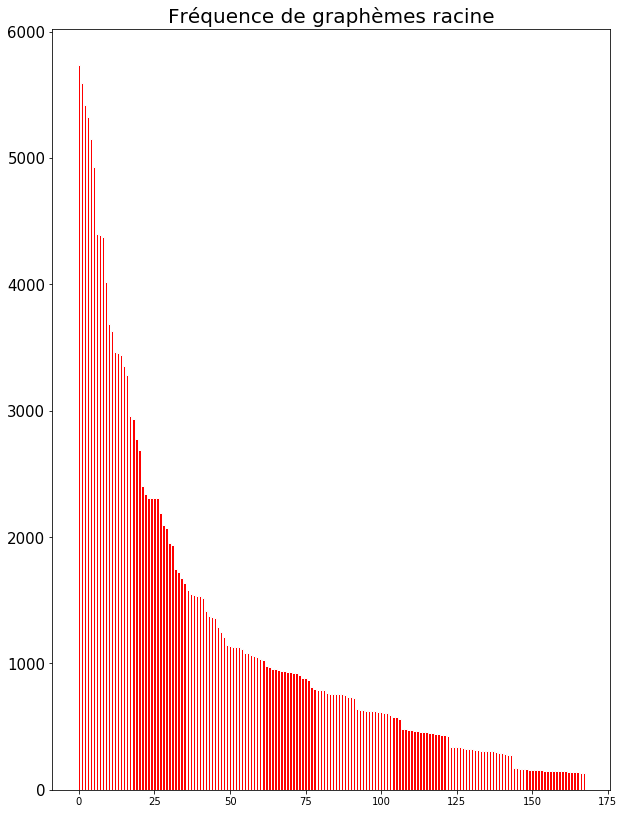

In [0]:
# !!!??? Pourqoui cette affichage ???
fig = plt.figure(figsize=(10, 14))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_title('Fréquence de graphèmes racine', fontsize=20)
#ax.tick_params(axis='both', which='major', labelsize=14)

# set height of bar
bars1 = count_roots['count']

# Make the plot
plt.bar(range(count_roots.shape[0]), bars1, color='red', edgecolor='white')

# Add yticks on the middle of the group bars
plt.yticks(fontsize=15)

# Show graphic
plt.show()

#### Graphèmes racine les plus courants

In [0]:
top_10_roots = get_n(train_df_, 'grapheme_root', 10)
top_10_roots

,index,component,count
72,72,দ,5736
64,64,ত,5596
13,13,ক,5420
107,107,ব,5321
23,23,গ,5149
96,96,প,4926
113,113,ভ,4395
147,147,স,4392
133,133,শ,4374
115,115,ম,4015


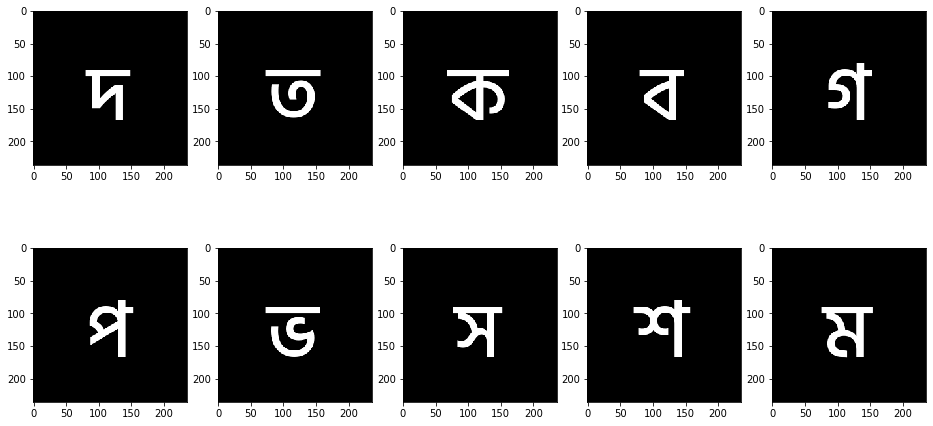

In [0]:
f, ax = plt.subplots(2, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(10):
    ax[i].imshow(image_from_char(top_10_roots['component'].iloc[i]), cmap='Greys')

#### Graphèmes racine les moins courants

In [0]:
bottom_10_roots = get_n(train_df_, 'grapheme_root', 10, False)
bottom_10_roots

,index,component,count
73,73,দ্ঘ,130
33,33,ঙ্ক্ত,136
102,102,প্স,141
158,158,স্স,143
45,45,জ্জ্ব,144
130,130,ল্ব,144
1,1,ঃ,145
12,12,ঔ,146
0,0,ং,147
63,63,ণ্ণ,149


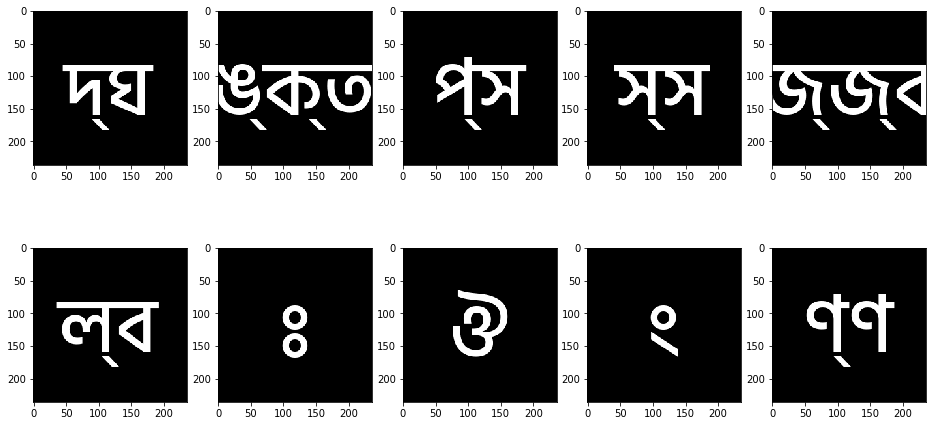

In [0]:
f, ax = plt.subplots(2, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(10):
    ax[i].imshow(image_from_char(bottom_10_roots['component'].iloc[i]), cmap='Greys')

### Diacritiques voyelles


#### Fréquences de diacritiques voyelles

In [0]:
count_vowels = get_n(train_df_, 'vowel_diacritic', train_df_.shape[0])

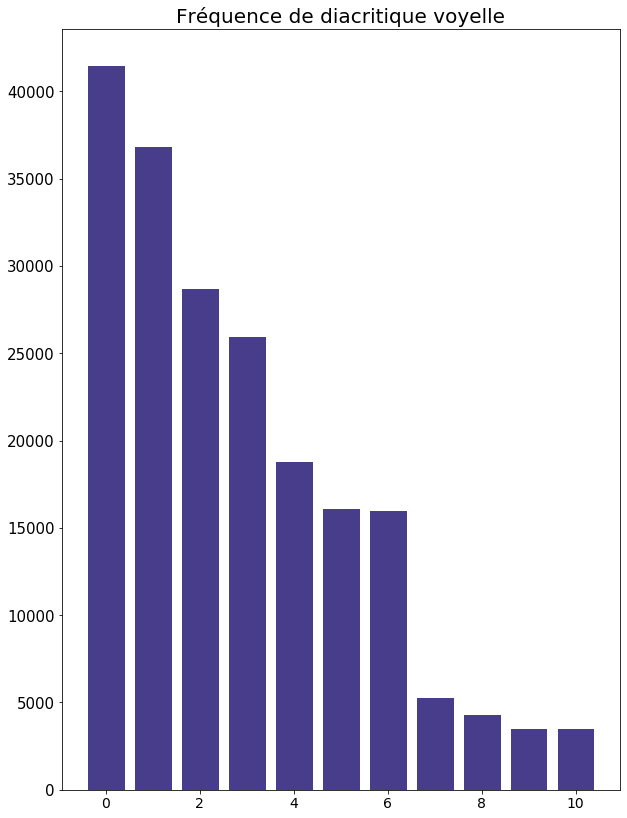

In [0]:
count_vowels = get_n(train_df_, 'vowel_diacritic', train_df_.size)
fig = plt.figure(figsize=(10, 14))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_title('Fréquence de diacritique voyelle', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

# set height of bar
bars1 = count_vowels['count']

# Make the plot
plt.bar(range(count_vowels.shape[0]), bars1, color='darkslateblue', edgecolor='white')

# Add xticks on the middle of the group bars
plt.yticks(fontsize=15)

# Show graphic
plt.show()

#### Diacritiques voyelles les plus courants

In [0]:
top_5_vowels = get_n(train_df_, 'vowel_diacritic', 5)
top_5_vowels

,index,component,count
0,168,0,41508
1,169,া,36886
7,175,ে,28723
2,170,ি,25967
4,172,ু,18848


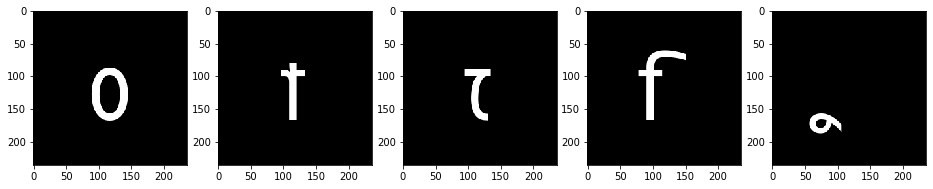

In [0]:
f, ax = plt.subplots(1, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(5):
    ax[i].imshow(image_from_char(top_5_vowels['component'].iloc[i]), cmap='Greys')

### Diacritiques consonnes 

#### Fréquences de diacritiques consonnes 

In [0]:
count_consonant = get_n(train_df_, 'consonant_diacritic', train_df_.shape[0])

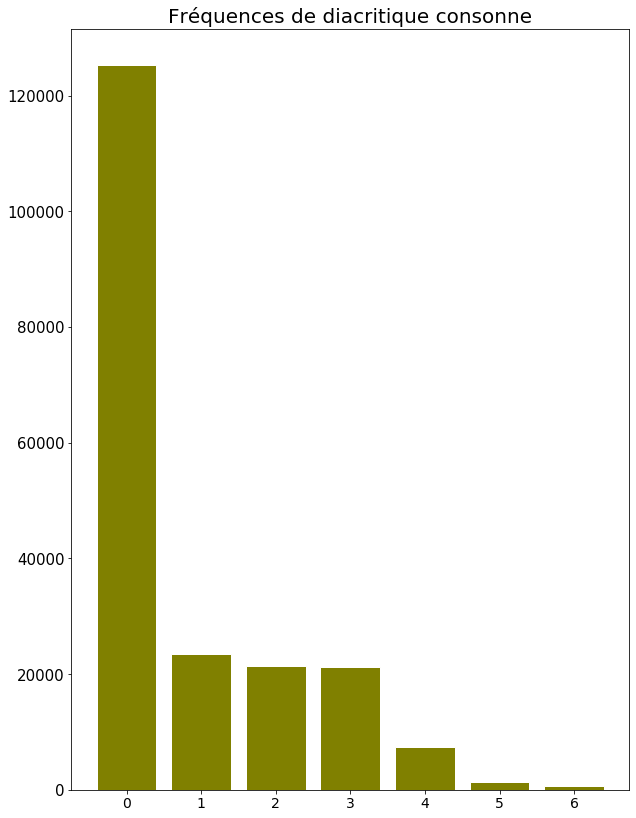

In [0]:
count_consonant = get_n(train_df_, 'consonant_diacritic', train_df_.size)
fig = plt.figure(figsize=(10, 14))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_title('Fréquences de diacritique consonne', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

# set height of bar
bars1 = count_consonant['count']

# Make the plot
plt.bar(range(count_consonant.shape[0]), bars1, color='olive', edgecolor='white')

# Add xticks on the middle of the group bars
plt.yticks(fontsize=15)

# Show graphic
plt.show()

#### Diacritiques consonnes les plus courants

In [0]:
top_5_consonants = get_n(train_df_, 'consonant_diacritic', 5)
top_5_consonants

,index,component,count
0,179,0,125278
2,181,র্,23465
5,184,্র,21397
4,183,্য,21270
1,180,ঁ,7424


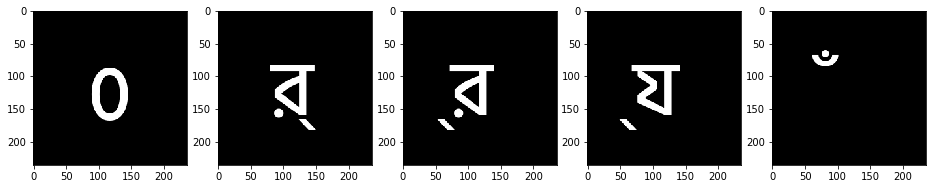

In [0]:
f, ax = plt.subplots(1, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(5):
    ax[i].imshow(image_from_char(top_5_consonants['component'].iloc[i]), cmap='Greys')

## Visualisation d'images de graphèmes

In [0]:
HEIGHT = 137 # real image size
WIDTH = 236 

def load_as_npa(file):
    df = pd.read_parquet(file)
    return df.iloc[:, 0], df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH)

### Batch d'images

In [0]:
image_ids0, images0 = load_as_npa('Data/bengaliai-cv19/train_image_data_0.parquet')

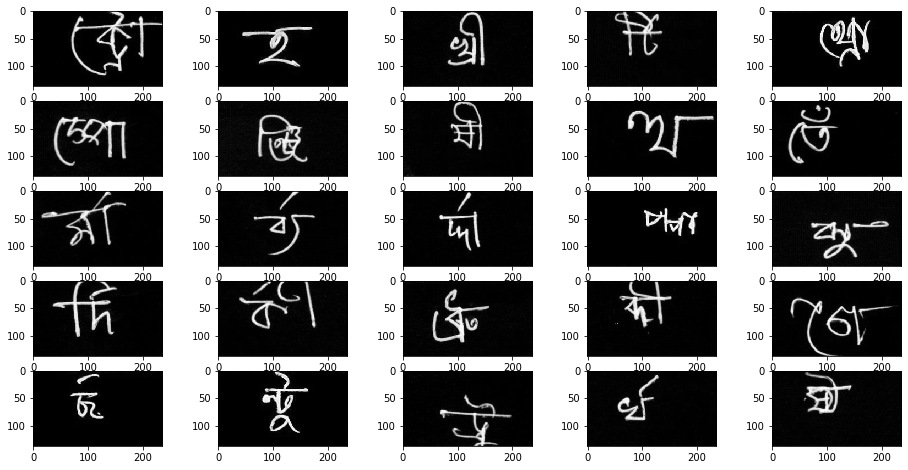

In [0]:
f, ax = plt.subplots(5, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(25):
    ax[i].imshow(images0[i], cmap='Greys')

### Différents représentations de graphème le plus courant

Source : Bengali - Quick EDA

Le graphème le plus courant est `দ`. La partie suivant nous permet de visualiser et explorer ses variantes écrites.

In [0]:
train_df = train_df_[0:50000]

#### Racine imprimée de graphème le plus courant

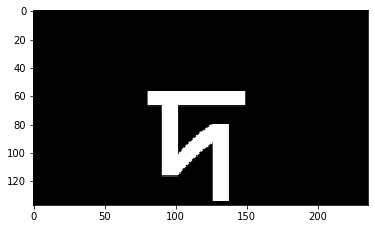

In [0]:
# Most common grapheme_root
gr_root_component = class_map_df[(class_map_df['component_type'] == 'grapheme_root') & (class_map_df['label'] == 72)]['component']
plt.imshow(image_from_char(gr_root_component[72]), cmap='Greys')


#### Les variantes imprimées de graphème le plus courant

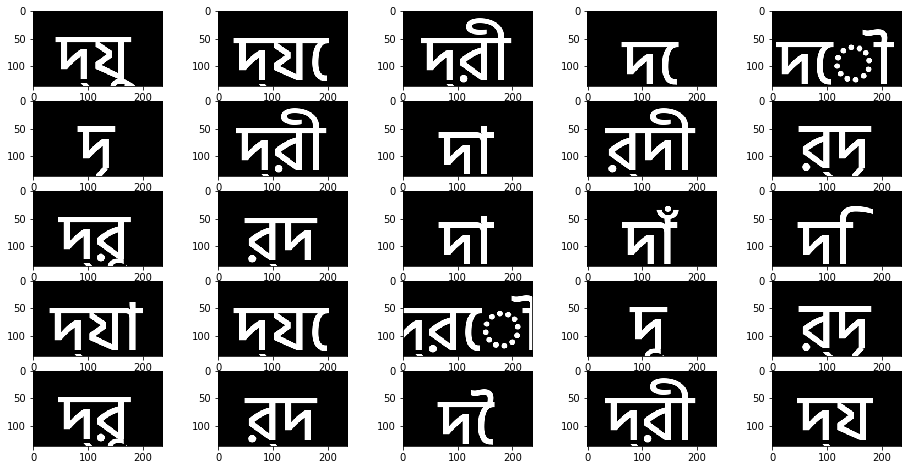

In [0]:
samples = train_df[train_df['grapheme_root'] == 72].sample(n=25)
#samples.reset_index(drop=True, inplace=True)

f, ax = plt.subplots(5, 5, figsize=(16, 8))
ax = ax.flatten()
k = 0
for i, row in samples.iterrows():
    ax[k].imshow(image_from_char(row['grapheme']), cmap='Greys')
    k = k + 1

#### Variantes écrites de graphème le plus courant

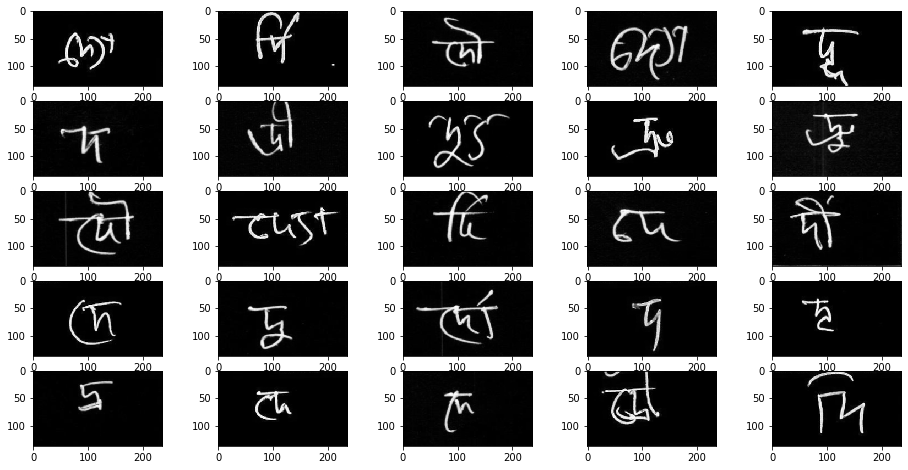

In [0]:
f, ax = plt.subplots(5, 5, figsize=(16, 8))
ax = ax.flatten()
k = 0
for i, row in samples.iterrows():
    ax[k].imshow(images0[i], cmap='Greys')
    k = k + 1

#### Exemples de graphème le plus courant écrit sans diacritique

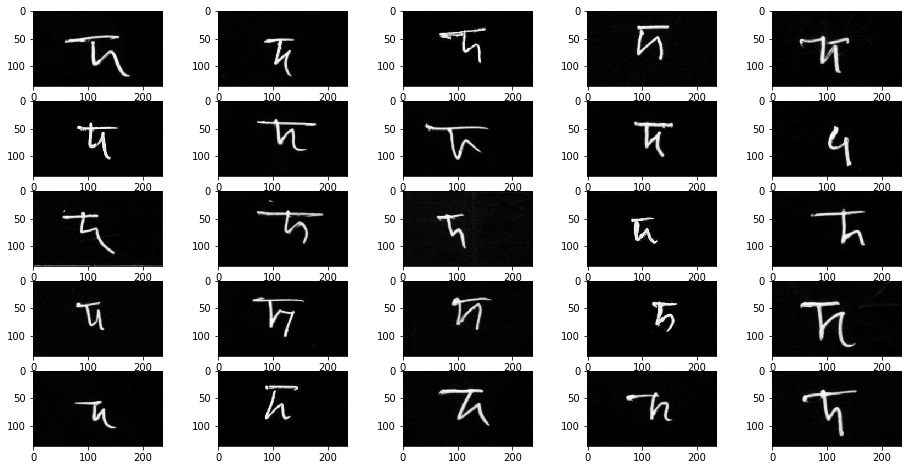

In [0]:
samples = train_df[
    (train_df['grapheme_root'] == 72) &
    (train_df['vowel_diacritic'] == 0) &
    (train_df['consonant_diacritic'] == 0)
].sample(n=25)

f, ax = plt.subplots(5, 5, figsize=(16, 8))
ax = ax.flatten()
k = 0
for i, row in samples.iterrows():
    ax[k].imshow(images0[i], cmap='Greys')
    k = k + 1

Après la partie d'analyse exploratoire, nous allons supprimer les données loadé dans la mémoire et libéré la mémoire avec le prompt gc.collect()

In [0]:
del train_df_
del test_df_
del class_map_df
del sample_sub_df
del count_roots
del top_10_roots
del bottom_10_roots
del count_vowels
del top_5_vowels
del count_consonant
del top_5_consonants
del image_ids0
del images0
del train_df_
del gr_root_component
del samples
gc.collect()

16292

# Modélisation

Dans la partie suivante, nous allons tester les modèles ResNet18 et SE-ResNet18 et comparer leurs performances. Afin de les pouvoir appliquer sur notre dataset, nous sommes obligés de customiser les modèles, notamment en modifiant la dimension de données en entrée (les modèles disponibles dans Keras contiennent obligtoirement 3 cannaux), ainsi que la dernière couche de sortie. Afin de modéliser les graphèmes racine, les consonnes et les voyelles, nous sommes obligés de programmer une sortie multioutput, c'est à dire une couche fully connected pour chaque output.

Etant donné que les graphèmes de bengali représente des images assez particulières et étant donné la taille de jeu de données d'entraînement (200k d’images), nous allons utiliser fine-tuning total, c'est à dire entraîner tout le réseau sur nos images.

Les fonctions pour créer les modèles et pour les entraînés sont créé à partir de Kernel public Bengali Graphemes: Multi Output ResNet-50 publié par Kaushal Shah. L'architecture de modèles était modifiée pour correspondre à celle de ResNet18, respectivement SE-ResNet18. 

Nous avons également ajouté un callback de Early stopping pour arrêter l’entraînement de modèle si la fonction de perte globale ne progresse plus au bout de 10 epochs, ainsi que le callback checkpoint qui enregistre le modèle le plus performant sur les données de validation.


## Charger les bibliothèques

In [1]:
# Pointer vers gdrive
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/Projet\ 8

/content/gdrive/My Drive/Colab Notebooks/Projet 8


In [3]:
import numpy as np 
import pandas as pd 
from tqdm.auto import tqdm
from glob import glob
import time, gc
import os
import cv2
import pydot

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import layer_utils, plot_model
from keras.utils.data_utils import get_file
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.initializers import glorot_uniform

from tensorflow.keras.applications.imagenet_utils import preprocess_input

from tensorflow.keras.models import Model, load_model, clone_model
from tensorflow.keras import layers
from tensorflow.keras.layers import (Dense, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, Dropout, BatchNormalization, Input, Add, 
Activation, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D, Reshape, Multiply)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
import seaborn as sns
from IPython.display import SVG

import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


## Feature engineering

Dans notre cas, le feature engineering constiste uniquement à redommensionner la taille des images pour correspondre à la taille exigée par le modèle. Pour l'instant, nous allons loader seulement le fichier de données d'entraînement, afin d'économiser RAM.

In [0]:
train_df_ = pd.read_csv('Data/bengaliai-cv19/train.csv')
test_df_ = pd.read_csv('Data/bengaliai-cv19/test.csv')
class_map_df = pd.read_csv('Data/bengaliai-cv19/class_map.csv')
sample_sub_df = pd.read_csv('Data/bengaliai-cv19/sample_submission.csv')

In [5]:
print(f"Taille de données d'entraînement: {train_df_.shape}")
print(f'Taille de données de test: {test_df_.shape}')
print(f'Taille de class map: {class_map_df.shape}')

Taille de données d'entraînement: (200840, 5)
Taille de données de test: (36, 3)
Taille de class map: (186, 3)


In [0]:
def resize(df, size=64, need_progress_bar=True):
    """Function which resizes the images to 64x64 pixels
    
    ARGS :
    - df : Data frame containing images pixels values
    - size : size of target image (64 pixels by default)
    - need_progress_bar : display progress bar (True by default)
    
    OUTPUT:
    - dataframe of resized images
    
    Source kernel: Bengali Graphemes_Multi Output ResNet-50  
    """
    
    resized = {}
    if need_progress_bar:
        for i in tqdm(range(df.shape[0])):
            image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size))
            resized[df.index[i]] = image.reshape(-1)
    else:
        for i in range(df.shape[0]):
            image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size))
            resized[df.index[i]] = image.reshape(-1)
    resized = pd.DataFrame(resized).T
    return resized

def get_dummies(df):
    """     
    
    Source kernel: Bengali Graphemes_Multi Output ResNet-50 """
    cols = []
    for col in df:
        cols.append(pd.get_dummies(df[col].astype(str)))
    return pd.concat(cols, axis=1)

Nous allons supprimer la variable grapheme de données d'entraînement (cette variable n'est pas utile pour la modélisation). Aussi, nous allons changer l'encodage de variables en uint8.

In [0]:
train_df_ = train_df_.drop(['grapheme'], axis=1, inplace=False)
train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] = train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8')

## ImageDataGenerator personnalisé

Afin de pouvoir travailler avec une sortie multiple, nous allons créer une classe MultiOutputDataGenerator, qui est une classe enfant d'ImageDataGenerator.

In [0]:
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):
    """Source kernel : Bengali Graphemes_ Multi Output ResNet-50"""

    def flow(self,
             x,
             y=None,
             batch_size=32, 
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

## ResNet18 multioutput



### Architecture


In [0]:
def identity_block(X, f, filters, stage, block):
    """
    ResNet Identity block

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape the CONV's window for the main path
    filters -- an integer defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    
    Source kernel : Bengali Graphemes_ Multi Output ResNet-50. The function was modified to correspond to 
    ResNet18 Architecture.
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filter 
       
    F = filters

    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X

    # Component of main path
    X = Conv2D(filters=F, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [0]:
def convolutional_block(X, f, filters, stage, block, s=2):
    """
    Implementation of the convolutional block

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- an integer specifying the shape of the middle CONV's window for the main path
    filters -- an integer defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    
    Source kernel : Bengali Graphemes_ Multi Output ResNet-50. The function was modified to correspond to 
    ResNet18 Architecture.
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters     
    F = filters

    # Save the input value
    X_shortcut = X

    # Second component of main path
    X = Conv2D(filters=F, kernel_size=(f, f), strides=(s, s), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters=F, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [0]:
def ResNet18(input_shape=(64, 64, 1)):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK1 -> IDBLOCK1 -> CONVBLOCK2 -> IDBLOCK2
    -> CONVBLOCK3 -> IDBLOCK3 -> CONVBLOCK4 -> IDBLOCK4 -> AVGPOOL -> TOPLAYERS

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    
    Source kernel : Bengali Graphemes_ Multi Output ResNet-50. The function was modified to correspond to 
    ResNet18 Architecture.
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # Stage 2
    X = convolutional_block(X, f=3, filters=64, stage=2, block='a', s=1)
    X = identity_block(X, 3, 64, stage=2, block='b')

    # Stage 3
    X = convolutional_block(X, f=3, filters=128, stage=3, block='a', s=2)
    X = identity_block(X, 3, 128, stage=3, block='b')

    # Stage 4
    X = convolutional_block(X, f=3, filters=256, stage=4, block='a', s=2)
    X = identity_block(X, 3, 256, stage=4, block='b')

    # Stage 5
    X = X = convolutional_block(X, f=3, filters=512, stage=5, block='a', s=2)
    X = identity_block(X, 3, 512, stage=5, block='b')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # output layers
    X = Flatten()(X)
    head_root = Dense(168, activation = 'softmax', kernel_initializer=glorot_uniform(seed=0))(X)
    head_vowel = Dense(11, activation = 'softmax', kernel_initializer=glorot_uniform(seed=0))(X)
    head_consonant = Dense(7, activation = 'softmax', kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=[head_root, head_vowel, head_consonant], name='ResNet18')

    return model

In [12]:
model = ResNet18(input_shape=(64, 64, 1))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
model.summary()

Model: "ResNet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [0]:
# Set up the training mode parameters
IMG_SIZE=64
N_CHANNELS=1
batch_size = 512
epochs = 25
n_parquets = 4 

In [0]:
# Set a learning rate annealer. Learning rate will be half after 3 epochs if accuracy is not increased
learning_rate_reduction_root = ReduceLROnPlateau(monitor='dense_acc', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_vowel = ReduceLROnPlateau(monitor='dense_1_acc', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_consonant = ReduceLROnPlateau(monitor='dense_2_acc', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:
# Save the best model (the most accurate model on validation data)
checkpoint_cb = keras.callbacks.ModelCheckpoint("resnet18.h5", save_best_only=True)

In [0]:
# Stop the training if the global loss function stops decreasing (no progress in 10 epochs)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, 
                                                              restore_best_weights=True, mode="min")  

### Entraînement de modèle

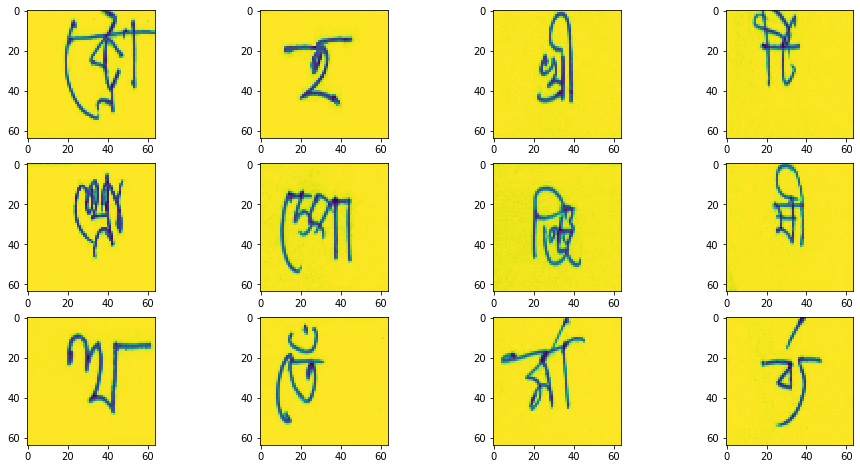


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/25
90/90 [==============================] - 35s 388ms/step - loss: 6.3737 - dense_loss: 4.4374 - dense_1_loss: 1.0505 - dense_2_loss: 0.8857 - dense_acc: 0.0618 - dense_1_acc: 0.6392 - dense_2_acc: 0.6944 - val_loss: 4.6957 - val_dense_loss: 3.6612 - val_dense_1_loss: 0.5343 - val_dense_2_loss: 0.5002 - val_dense_acc: 0.1481 - val_dense_1_acc: 0.8140 - val_dense_2_acc: 0.8205
Epoch 2/25
90/90 [==============================] - 25s 274ms/step - loss: 4.3545 - dense_loss: 3.2450 - dense_1_loss: 0.5773 - dense_2_loss: 0.5323 - dense_acc: 0.2051 - dense_1_acc: 0.8007 - dense_2_acc: 0.8132 - val_loss: 3.1561 - val_dense_loss: 2.4296 - val_dense_1_loss: 0.3502 - val_dense_2_loss: 0.3763 - val_dense_acc: 0.3493 - val_dense_1_acc: 0.8793 - val_dense_2_acc: 0.8643
Epoch 3/25
90/90 [==============================] - 26s 293ms/step - loss: 3.060

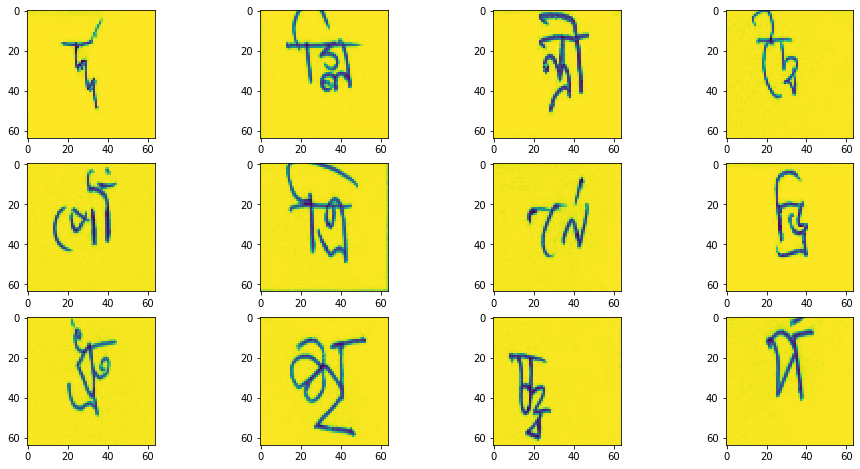


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/25
90/90 [==============================] - 26s 290ms/step - loss: 0.9511 - dense_loss: 0.6030 - dense_1_loss: 0.1687 - dense_2_loss: 0.1794 - dense_acc: 0.8233 - dense_1_acc: 0.9456 - dense_2_acc: 0.9395 - val_loss: 0.7190 - val_dense_loss: 0.4680 - val_dense_1_loss: 0.1242 - val_dense_2_loss: 0.1269 - val_dense_acc: 0.8653 - val_dense_1_acc: 0.9602 - val_dense_2_acc: 0.9597
Epoch 2/25
90/90 [==============================] - 26s 294ms/step - loss: 0.8208 - dense_loss: 0.5120 - dense_1_loss: 0.1509 - dense_2_loss: 0.1579 - dense_acc: 0.8423 - dense_1_acc: 0.9517 - dense_2_acc: 0.9461 - val_loss: 0.6729 - val_dense_loss: 0.4369 - val_dense_1_loss: 0.1146 - val_dense_2_loss: 0.1214 - val_dense_acc: 0.8698 - val_dense_1_acc: 0.9664 - val_dense_2_acc: 0.9642
Epoch 3/25
90/90 [==============================] - 26s 284ms/step - loss: 0.751

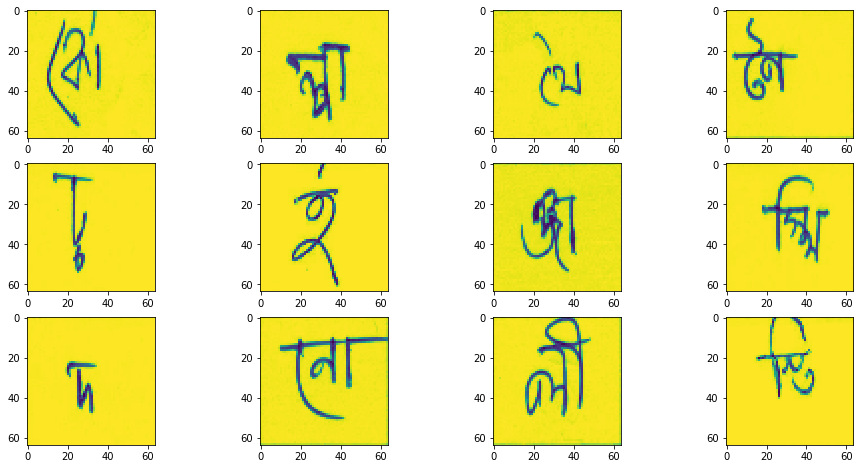


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/25
90/90 [==============================] - 27s 300ms/step - loss: 0.6778 - dense_loss: 0.4215 - dense_1_loss: 0.1214 - dense_2_loss: 0.1349 - dense_acc: 0.8781 - dense_1_acc: 0.9634 - dense_2_acc: 0.9572 - val_loss: 0.5269 - val_dense_loss: 0.3467 - val_dense_1_loss: 0.0868 - val_dense_2_loss: 0.0934 - val_dense_acc: 0.9009 - val_dense_1_acc: 0.9773 - val_dense_2_acc: 0.9711
Epoch 2/25
90/90 [==============================] - 26s 288ms/step - loss: 0.5845 - dense_loss: 0.3608 - dense_1_loss: 0.1053 - dense_2_loss: 0.1184 - dense_acc: 0.8930 - dense_1_acc: 0.9666 - dense_2_acc: 0.9605 - val_loss: 0.5093 - val_dense_loss: 0.3320 - val_dense_1_loss: 0.0893 - val_dense_2_loss: 0.0880 - val_dense_acc: 0.9052 - val_dense_1_acc: 0.9746 - val_dense_2_acc: 0.9709
Epoch 3/25
90/90 [==============================] - 26s 292ms/step - loss: 0.536

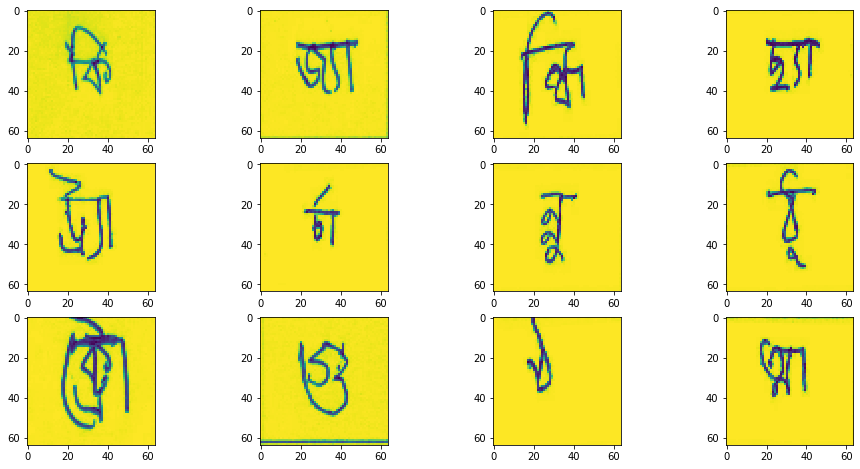


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/25
90/90 [==============================] - 27s 301ms/step - loss: 0.5908 - dense_loss: 0.3653 - dense_1_loss: 0.1096 - dense_2_loss: 0.1159 - dense_acc: 0.8934 - dense_1_acc: 0.9656 - dense_2_acc: 0.9617 - val_loss: 0.4602 - val_dense_loss: 0.2979 - val_dense_1_loss: 0.0913 - val_dense_2_loss: 0.0710 - val_dense_acc: 0.9101 - val_dense_1_acc: 0.9778 - val_dense_2_acc: 0.9776
Epoch 2/25
90/90 [==============================] - 26s 293ms/step - loss: 0.5300 - dense_loss: 0.3224 - dense_1_loss: 0.1010 - dense_2_loss: 0.1066 - dense_acc: 0.9008 - dense_1_acc: 0.9682 - dense_2_acc: 0.9646 - val_loss: 0.4533 - val_dense_loss: 0.2892 - val_dense_1_loss: 0.0912 - val_dense_2_loss: 0.0730 - val_dense_acc: 0.9114 - val_dense_1_acc: 0.9764 - val_dense_2_acc: 0.9778
Epoch 3/25
90/90 [==============================] - 26s 294ms/step - loss: 0.498

In [18]:
# Measure the time of execution
start_time = time.time()

histories = []
for i in range(n_parquets):
    train_df = pd.merge(pd.read_parquet(
        f'Data/bengaliai-cv19/train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)

    # Visualize few samples of current training dataset
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
    count = 0
    for row in ax:
        for col in row:
            col.imshow(resize(train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[
                       count]], need_progress_bar=False).values.reshape(64, 64))
            count += 1
    plt.show()

    X_train = train_df.drop(
        ['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
    X_train = resize(X_train)/255.  

    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
    X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)

    Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
    Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
    Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

    print(f'Training images: {X_train.shape}')
    print(f'Training labels root: {Y_train_root.shape}')
    print(f'Training labels vowel: {Y_train_vowel.shape}')
    print(f'Training labels consonants: {Y_train_consonant.shape}')

    # Divide the data into training and validation set
    x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(
        X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.08, random_state=666)
    del train_df
    del X_train
    del Y_train_root, Y_train_vowel, Y_train_consonant

    # Data augmentation for creating more training data
    datagen = MultiOutputDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        # randomly rotate images in the range (degrees, 0 to 180)
        rotation_range=8,
        zoom_range=0.15,  # Randomly zoom image
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.15,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.15,
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # This will just calculate parameters required to augment the given data. This won't perform any augmentations
    datagen.fit(x_train)

    # Fit the model
    history = model.fit_generator(datagen.flow(x_train, {'dense': y_train_root, 'dense_1': y_train_vowel, 'dense_2': y_train_consonant}, batch_size=batch_size),  # Dense renamed
                                  epochs=epochs, validation_data=(
                                      x_test, [y_test_root, y_test_vowel, y_test_consonant]),
                                  steps_per_epoch=x_train.shape[0] // batch_size,
                                  callbacks=[learning_rate_reduction_root, learning_rate_reduction_vowel,
                                             learning_rate_reduction_consonant, checkpoint_cb, early_stopping_cb])

    histories.append(history)

    # Delete to reduce memory usage
    del x_train
    del x_test
    del y_train_root
    del y_test_root
    del y_train_vowel
    del y_test_vowel
    del y_train_consonant
    del y_test_consonant
    gc.collect()

# Print the time of execution
print("--- " + str(int((time.time() - start_time)//3600)) + " hours "
      + str(int(((time.time() - start_time) % 3600)//60)) + " mins ---")

### Evaluation

In [0]:
%matplotlib inline
def plot_loss(his, title):
   """Function which plots the history of training, in this case the evolution of training and validation loss function.
     
   ARGS : 
   - his : keras history object
   - title : str with title of each plot
    
   OUT :
   - plot of training curve    
   """

   plt.style.use('ggplot')
   plt.figure()
   plt.plot(np.arange(0, len(his.history['loss'])), his.history['loss'], label='train_loss')
   plt.plot(np.arange(0, len(his.history['loss'])), his.history['dense_loss'], label='train_root_loss')
   plt.plot(np.arange(0, len(his.history['loss'])), his.history['dense_1_loss'], label='train_vowel_loss')
   plt.plot(np.arange(0, len(his.history['loss'])), his.history['dense_2_loss'], label='train_consonant_loss')
    
   plt.plot(np.arange(0, len(his.history['loss'])), his.history['val_dense_loss'], label='val_train_root_loss')
   plt.plot(np.arange(0, len(his.history['loss'])), his.history['val_dense_1_loss'], label='val_train_vowel_loss')
   plt.plot(np.arange(0, len(his.history['loss'])), his.history['val_dense_2_loss'], label='val_train_consonant_loss')
    
   plt.title(title)
   plt.xlabel('Epoch #/' + str(len(his.history['loss'])))
   plt.ylabel('Loss')
   plt.legend(loc='upper right')
   plt.show()

def plot_acc(his, title):
   """Function which plots the history of training, in this case the evolution of training and validation accuracy.
     
   ARGS : 
   - his : keras history object
   - title : str with title of each plot
    
   OUT :
   - plot of training curve    
   """
   plt.style.use('ggplot')
   plt.figure()
   plt.plot(np.arange(0, len(his.history['dense_acc'])), his.history['dense_acc'], label='train_root_acc')
   plt.plot(np.arange(0, len(his.history['dense_acc'])), his.history['dense_1_acc'], label='train_vowel_acc')
   plt.plot(np.arange(0, len(his.history['dense_acc'])), his.history['dense_2_acc'], label='train_consonant_acc')
    
   plt.plot(np.arange(0, len(his.history['dense_acc'])), his.history['val_dense_acc'], label='val_root_acc')
   plt.plot(np.arange(0, len(his.history['dense_acc'])), his.history['val_dense_1_acc'], label='val_vowel_acc')
   plt.plot(np.arange(0, len(his.history['dense_acc'])), his.history['val_dense_2_acc'], label='val_consonant_acc')
   plt.title(title)
   plt.xlabel('Epoch # /' + str(len(his.history['dense_acc'])))
   plt.ylabel('Accuracy')
   plt.legend(loc='lower right')
   plt.show()

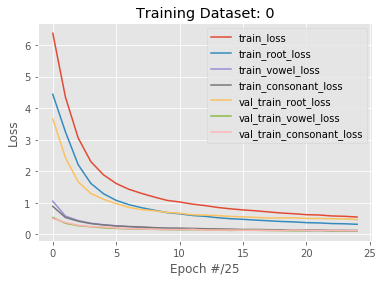

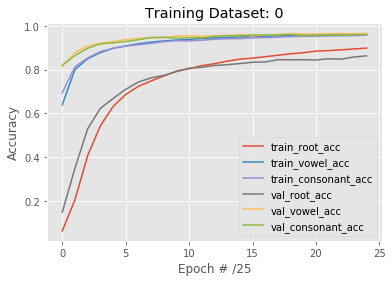

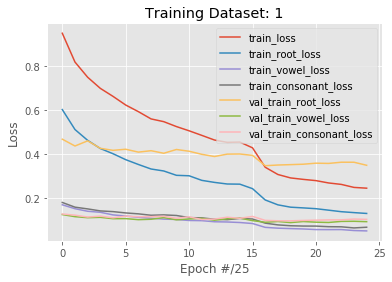

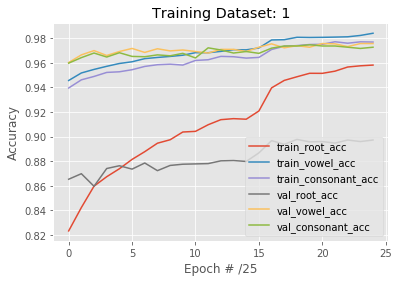

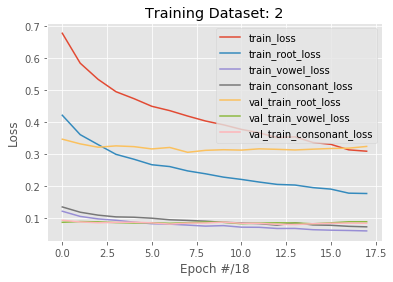

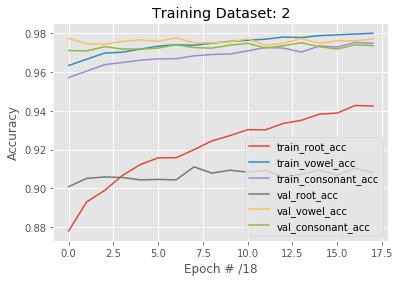

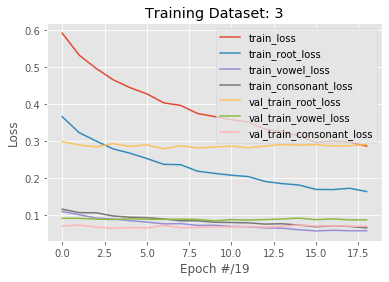

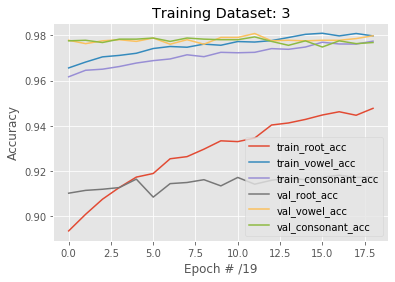

In [20]:
# Plot the learning curves for 4 datasets
for dataset in range(n_parquets): 
    plot_loss(histories[dataset],  f'Training Dataset: {dataset}')
    plot_acc(histories[dataset],  f'Training Dataset: {dataset}')

In [0]:
def best_acc(var):
    """ Function which calculate the best accuracy score for any component
    ARGS : 
    - var : str with the component name (eg. 'val_dense_acc')

    OUT :
    - Max value of accuracy    
    """
    max_acc = []
    for i in range(n_parquets):
        best_acc = max(histories[i].history[var])
        max_acc.append(best_acc)
        max_accuracy = max(max_acc)
        return max_accuracy

In [0]:
score1 = round(best_acc('val_dense_acc'), 4)
score2 = round(best_acc('val_dense_1_acc'), 4)
score3 = round(best_acc('val_dense_2_acc'), 4)

print ("Grapheme root best validation accuracy : " + str(score1))
print ("Vowel diacritique best validation accuracy : " + str(score2))
print ("Consonant diacritique best validation accuracy : " + str(score3))

Grapheme root best validation accuracy : 0.8566
Vowel diacritique best validation accuracy : 0.9689
Consonant diacritique best validation accuracy : 0.9647


In [0]:
score = round((score1*2 + score2 + score3)/4,4)

print ("The estimated Kaggle score : " + str(score))

The estimated Kaggle score : 0.9117


In [0]:
# Delete histories to clean the memory
del histories
gc.collect()

30557

In [0]:
# Create dictionnary of predictions
preds_dict = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}

In [0]:
# Generate the submission .csv file
components = ['consonant_diacritic', 'grapheme_root', 'vowel_diacritic']
target=[] # model predictions placeholder
row_id=[] # row_id place holder
for i in range(n_parquets): 
    df_test_img = pd.read_parquet('Data/bengaliai-cv19/test_image_data_{}.parquet'.format(i)) 
    df_test_img.set_index('image_id', inplace=True)

    X_test = resize(df_test_img, need_progress_bar=False)/255
    X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    preds = model.predict(X_test)

    for i, p in enumerate(preds_dict):
        preds_dict[p] = np.argmax(preds[i], axis=1)

    for k,id in enumerate(df_test_img.index.values):  
        for i,comp in enumerate(components):
            id_sample=id+'_'+comp
            row_id.append(id_sample)
            target.append(preds_dict[comp][k])
    del df_test_img
    del X_test
    gc.collect()

df_sample = pd.DataFrame(
    {
        'row_id': row_id,
        'target':target
    },
    columns = ['row_id','target'] 
)
df_sample.to_csv('submission.csv',index=False)
df_sample.head()

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,64
2,Test_0_vowel_diacritic,1
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,93


## SE-ResNet18 multioutput

### Architecture 

Nous allons modifier le modèle SE-ResNet18 en ajoutant le block SE (Squeeze and Excitation). Il s'agit de module qui agit sur les couches en profondeur et qui ré-équilibre les poids de feature maps. Il est constitué d'une couche de global average pooling et de deux couches fully connected.


In [0]:
def identity_block(X, f, filters, stage, block):
    """
    ResNet Identity block

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape the CONV's window for the main path
    filters -- an integer defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filter 
       
    F = filters

    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X

    # Component of main path
    X = Conv2D(filters=F, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # SE component
    se = GlobalAveragePooling2D(name='pool' + str(stage) + block + '_gap')(X)
    se = Dense(F // 16, activation='relu', name = 'fc' + str(stage) + block + '_sqz')(se)
    se = Dense(F, activation='sigmoid', name = 'fc' + str(stage) + block + '_exc')(se)
    se = Reshape([1, 1, F])(se)
    X = Multiply(name='scale' + str(stage) + block)([X, se])
      
    
    # Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [0]:
def convolutional_block(X, f, filters, stage, block, s=2):
    """
    Implementation of the convolutional block

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- an integer specifying the shape of the middle CONV's window for the main path
    filters -- an integer defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters     
    F = filters

    # Save the input value
    X_shortcut = X

    # Second component of main path
    X = Conv2D(filters=F, kernel_size=(f, f), strides=(s, s), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters=F, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)
    
    # SE component
    se = GlobalAveragePooling2D(name='pool' + str(stage) + block + '_gap')(X)
    se = Dense(F // 16, activation='relu', name = 'fc' + str(stage) + block + '_sqz')(se)
    se = Dense(F, activation='sigmoid', name = 'fc' + str(stage) + block + '_exc')(se)
    se = Reshape([1, 1, F])(se)
    X = Multiply(name='scale' + str(stage) + block)([X, se])

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [0]:
def SE_ResNet18(input_shape=(64, 64, 1)):
    """
    Implementation of the popular ResNet18 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK1 -> IDBLOCK1 -> CONVBLOCK2 -> IDBLOCK2
    -> CONVBLOCK3 -> IDBLOCK3 -> CONVBLOCK4 -> IDBLOCK4 -> AVGPOOL -> TOPLAYERS

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # Stage 2
    X = convolutional_block(X, f=3, filters=64, stage=2, block='a', s=1)
    X = identity_block(X, 3, 64, stage=2, block='b')

    # Stage 3
    X = convolutional_block(X, f=3, filters=128, stage=3, block='a', s=2)
    X = identity_block(X, 3, 128, stage=3, block='b')

    # Stage 4
    X = convolutional_block(X, f=3, filters=256, stage=4, block='a', s=2)
    X = identity_block(X, 3, 256, stage=4, block='b')

    # Stage 5
    X = X = convolutional_block(X, f=3, filters=512, stage=5, block='a', s=2)
    X = identity_block(X, 3, 512, stage=5, block='b')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # output layers
    X = Flatten()(X)
    head_root = Dense(168, activation = 'softmax', kernel_initializer=glorot_uniform(seed=0))(X)
    head_vowel = Dense(11, activation = 'softmax', kernel_initializer=glorot_uniform(seed=0))(X)
    head_consonant = Dense(7, activation = 'softmax', kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=[head_root, head_vowel, head_consonant], name='SE-ResNet18')

    return model

In [12]:
model = SE_ResNet18(input_shape=(64, 64, 1))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
model.summary()

Model: "SE-ResNet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 1)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   3200        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
________________________________________________________________________________________

In [0]:
IMG_SIZE=64
N_CHANNELS=1
batch_size = 512
epochs = 25
n_parquets = 4

In [0]:
# Set a learning rate annealer. Learning rate will be half after 3 epochs if accuracy is not increased
learning_rate_reduction_root = ReduceLROnPlateau(monitor='dense_acc', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_vowel = ReduceLROnPlateau(monitor='dense_1_acc', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_consonant = ReduceLROnPlateau(monitor='dense_2_acc', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:
# Save the best model (the most accurate model on validation data)
checkpoint_cb = keras.callbacks.ModelCheckpoint("se_resnet18.h5", save_best_only=True)

In [0]:
# Stop the training if the global loss function stops decreasing (no progress in 10 epochs)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, 
                                                              restore_best_weights=True, mode="min")  

### Entraînement de modèle

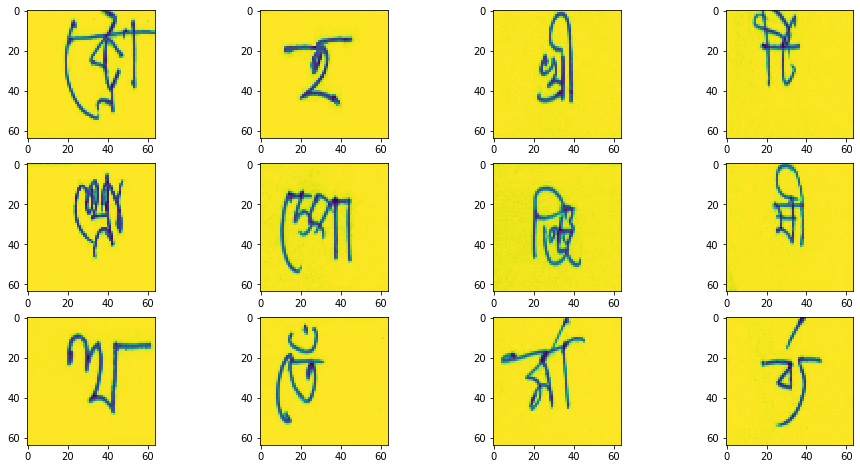


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/25
90/90 [==============================] - 34s 375ms/step - loss: 6.4875 - dense_loss: 4.4711 - dense_1_loss: 1.0990 - dense_2_loss: 0.9174 - dense_acc: 0.0538 - dense_1_acc: 0.6212 - dense_2_acc: 0.6816 - val_loss: 5.0114 - val_dense_loss: 3.8644 - val_dense_1_loss: 0.5738 - val_dense_2_loss: 0.5732 - val_dense_acc: 0.1143 - val_dense_1_acc: 0.8041 - val_dense_2_acc: 0.7884
Epoch 2/25
90/90 [==============================] - 24s 265ms/step - loss: 4.6362 - dense_loss: 3.4847 - dense_1_loss: 0.5943 - dense_2_loss: 0.5573 - dense_acc: 0.1651 - dense_1_acc: 0.7925 - dense_2_acc: 0.7994 - val_loss: 3.5298 - val_dense_loss: 2.7508 - val_dense_1_loss: 0.3907 - val_dense_2_loss: 0.3883 - val_dense_acc: 0.2833 - val_dense_1_acc: 0.8710 - val_dense_2_acc: 0.8658
Epoch 3/25
90/90 [==============================] - 25s 280ms/step - loss: 3.394

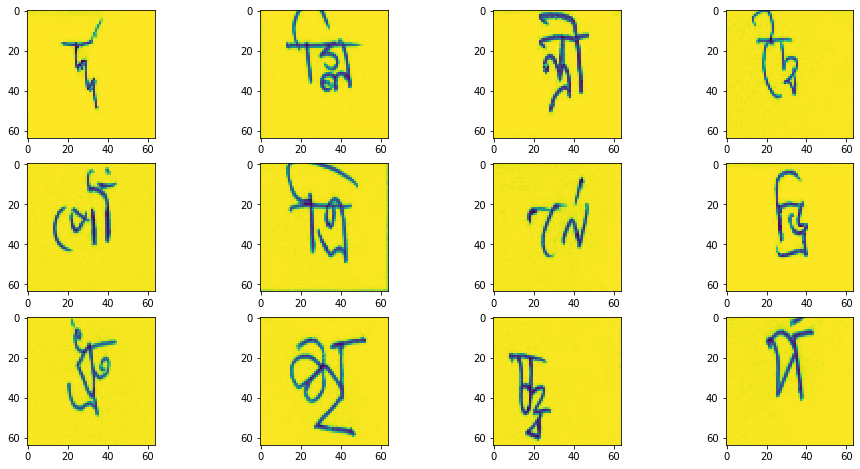


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/25
90/90 [==============================] - 26s 284ms/step - loss: 0.9501 - dense_loss: 0.6012 - dense_1_loss: 0.1689 - dense_2_loss: 0.1799 - dense_acc: 0.8227 - dense_1_acc: 0.9461 - dense_2_acc: 0.9402 - val_loss: 0.7403 - val_dense_loss: 0.4922 - val_dense_1_loss: 0.1253 - val_dense_2_loss: 0.1228 - val_dense_acc: 0.8486 - val_dense_1_acc: 0.9647 - val_dense_2_acc: 0.9609
Epoch 2/25
90/90 [==============================] - 26s 291ms/step - loss: 0.8324 - dense_loss: 0.5238 - dense_1_loss: 0.1475 - dense_2_loss: 0.1611 - dense_acc: 0.8397 - dense_1_acc: 0.9518 - dense_2_acc: 0.9444 - val_loss: 0.7041 - val_dense_loss: 0.4609 - val_dense_1_loss: 0.1162 - val_dense_2_loss: 0.1269 - val_dense_acc: 0.8601 - val_dense_1_acc: 0.9671 - val_dense_2_acc: 0.9617
Epoch 3/25
90/90 [==============================] - 26s 291ms/step - loss: 0.771

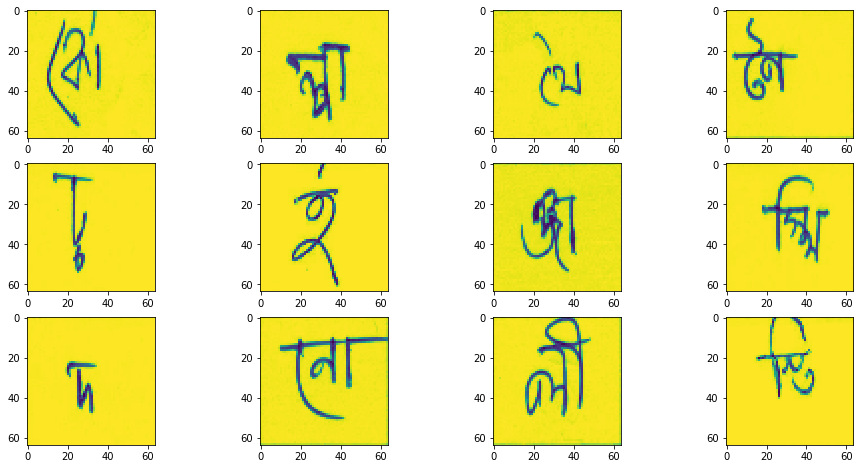


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/25
90/90 [==============================] - 26s 285ms/step - loss: 0.7964 - dense_loss: 0.5016 - dense_1_loss: 0.1425 - dense_2_loss: 0.1523 - dense_acc: 0.8546 - dense_1_acc: 0.9556 - dense_2_acc: 0.9497 - val_loss: 0.5945 - val_dense_loss: 0.3931 - val_dense_1_loss: 0.1013 - val_dense_2_loss: 0.1002 - val_dense_acc: 0.8818 - val_dense_1_acc: 0.9679 - val_dense_2_acc: 0.9639
Epoch 2/25
90/90 [==============================] - 26s 292ms/step - loss: 0.6579 - dense_loss: 0.4026 - dense_1_loss: 0.1208 - dense_2_loss: 0.1346 - dense_acc: 0.8784 - dense_1_acc: 0.9612 - dense_2_acc: 0.9542 - val_loss: 0.5634 - val_dense_loss: 0.3738 - val_dense_1_loss: 0.0934 - val_dense_2_loss: 0.0962 - val_dense_acc: 0.8915 - val_dense_1_acc: 0.9709 - val_dense_2_acc: 0.9681
Epoch 3/25
90/90 [==============================] - 25s 280ms/step - loss: 0.594

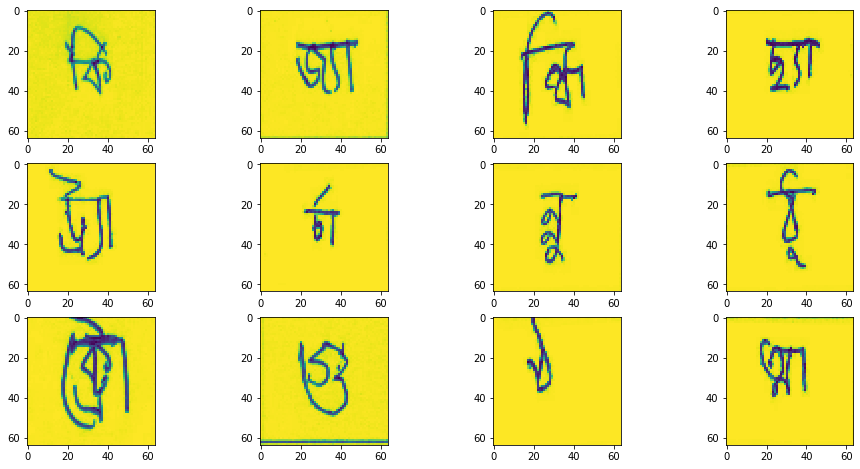


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/25
90/90 [==============================] - 26s 286ms/step - loss: 0.7037 - dense_loss: 0.4442 - dense_1_loss: 0.1252 - dense_2_loss: 0.1342 - dense_acc: 0.8694 - dense_1_acc: 0.9608 - dense_2_acc: 0.9548 - val_loss: 0.5334 - val_dense_loss: 0.3612 - val_dense_1_loss: 0.0919 - val_dense_2_loss: 0.0802 - val_dense_acc: 0.8895 - val_dense_1_acc: 0.9721 - val_dense_2_acc: 0.9759
Epoch 2/25
90/90 [==============================] - 26s 292ms/step - loss: 0.6073 - dense_loss: 0.3688 - dense_1_loss: 0.1146 - dense_2_loss: 0.1239 - dense_acc: 0.8871 - dense_1_acc: 0.9630 - dense_2_acc: 0.9585 - val_loss: 0.5071 - val_dense_loss: 0.3322 - val_dense_1_loss: 0.0937 - val_dense_2_loss: 0.0812 - val_dense_acc: 0.8982 - val_dense_1_acc: 0.9741 - val_dense_2_acc: 0.9739
Epoch 3/25
90/90 [==============================] - 25s 280ms/step - loss: 0.538

In [18]:
# Measure the time of execution
start_time = time.time()

histories = []
for i in range(n_parquets):
    train_df = pd.merge(pd.read_parquet(f'Data/bengaliai-cv19/train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)
    
    # Visualize few samples of current training dataset
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
    count=0
    for row in ax:
        for col in row:
            col.imshow(resize(train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[count]], need_progress_bar=False).values.reshape(64, 64))
            count += 1
    plt.show()
    
    X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
    X_train = resize(X_train)/255. 
    
    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
    X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
    Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
    Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

    print(f'Training images: {X_train.shape}')
    print(f'Training labels root: {Y_train_root.shape}')
    print(f'Training labels vowel: {Y_train_vowel.shape}')
    print(f'Training labels consonants: {Y_train_consonant.shape}')

    # Divide the data into training and validation set
    x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.08, random_state=666)
    del train_df
    del X_train
    del Y_train_root, Y_train_vowel, Y_train_consonant

    # Data augmentation for creating more training data
    datagen = MultiOutputDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


    # This will just calculate parameters required to augment the given data. This won't perform any augmentations
    datagen.fit(x_train)

    # Fit the model
    history = model.fit_generator(datagen.flow(x_train, {'dense': y_train_root, 'dense_1': y_train_vowel, 'dense_2': y_train_consonant}, batch_size=batch_size), # Dense renamed
                              epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
                              steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction_root, learning_rate_reduction_vowel, 
                                         learning_rate_reduction_consonant, checkpoint_cb, early_stopping_cb])

    histories.append(history)
    
    # Delete to reduce memory usage
    del x_train
    del x_test
    del y_train_root
    del y_test_root
    del y_train_vowel
    del y_test_vowel
    del y_train_consonant
    del y_test_consonant
    gc.collect()
    
# Print the time of execution
print("--- " + str(int((time.time() - start_time)//3600)) + " hours " 
      + str(int(((time.time() - start_time)%3600)//60)) + " mins ---")

### Evaluation

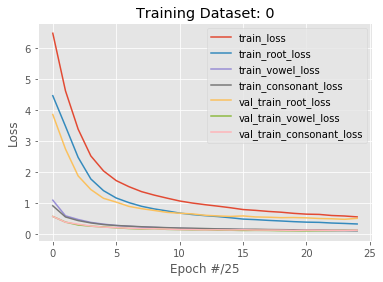

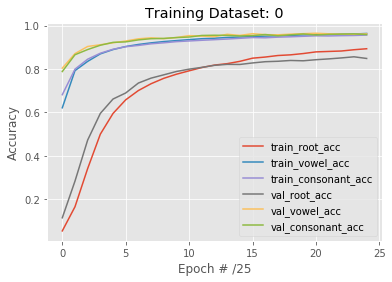

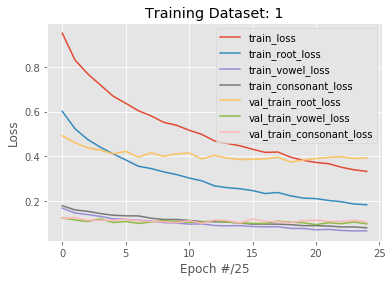

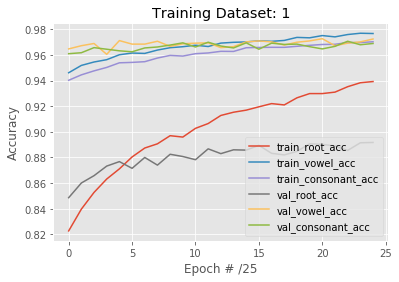

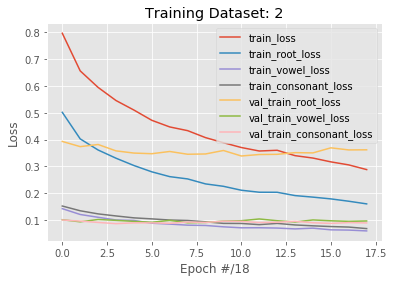

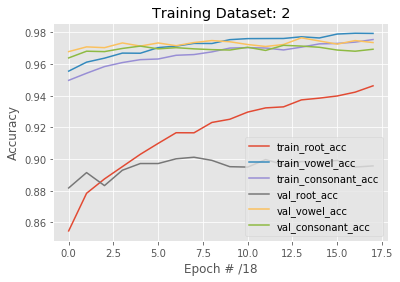

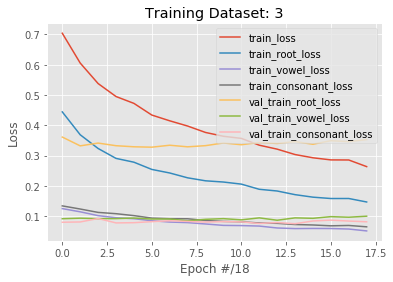

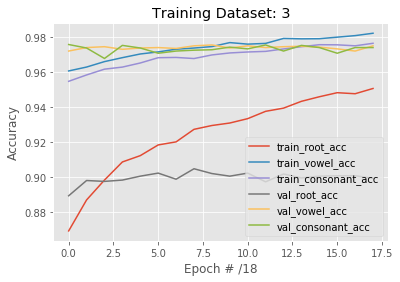

In [21]:
for dataset in range(n_parquets): 
    plot_loss(histories[dataset],  f'Training Dataset: {dataset}')
    plot_acc(histories[dataset],  f'Training Dataset: {dataset}')

In [0]:
score1 = round(best_acc('val_dense_acc'), 4)
score2 = round(best_acc('val_dense_1_acc'), 4)
score3 = round(best_acc('val_dense_2_acc'), 4)

print ("Grapheme root best validation accuracy : " + str(score1))
print ("Vowel diacritique best validation accuracy : " + str(score2))
print ("Consonant diacritique best validation accuracy : " + str(score3))

Grapheme root best validation accuracy : 0.8588
Vowel diacritique best validation accuracy : 0.9691
Consonant diacritique best validation accuracy : 0.9659


In [0]:
score = round((score1*2 + score2 + score3)/4,4)

print ("The estimated Kaggle score : " + str(score))

The estimated Kaggle score : 0.9131


In [0]:
del histories
gc.collect()

30005

In [0]:
preds_dict = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}

In [0]:
components = ['consonant_diacritic', 'grapheme_root', 'vowel_diacritic']
target=[] # model predictions placeholder
row_id=[] # row_id place holder
for i in range(n_parquets): 
    df_test_img = pd.read_parquet('Data/bengaliai-cv19/test_image_data_{}.parquet'.format(i)) 
    df_test_img.set_index('image_id', inplace=True)

    X_test = resize(df_test_img, need_progress_bar=False)/255
    X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    preds = model.predict(X_test)

    for i, p in enumerate(preds_dict):
        preds_dict[p] = np.argmax(preds[i], axis=1)

    for k,id in enumerate(df_test_img.index.values):  
        for i,comp in enumerate(components):
            id_sample=id+'_'+comp
            row_id.append(id_sample)
            target.append(preds_dict[comp][k])
    del df_test_img
    del X_test
    gc.collect()

df_sample = pd.DataFrame(
    {
        'row_id': row_id,
        'target':target
    },
    columns = ['row_id','target'] 
)
df_sample.to_csv('submission2.csv',index=False)
df_sample.head()

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,3
2,Test_0_vowel_diacritic,1
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,76
